In [2]:
# change directory to sssl folder
%cd ..

/gpfs01/berens/user/jdoehl/GitHub/sssl


In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2
from utils.plotting_utils import *

env: CUDA_VISIBLE_DEVICES=2


In [ ]:
path = "logs/Balanced-1000/stereo/version_0/checkpoint/epoch=999.ckpt"
embed_dict_stereo = get_embeds_for_ckpt(path, cifar10_train)
plot_images_per_class_with_norm_close_to_0_intersect_of_extra_dim(embed_dict_stereo)

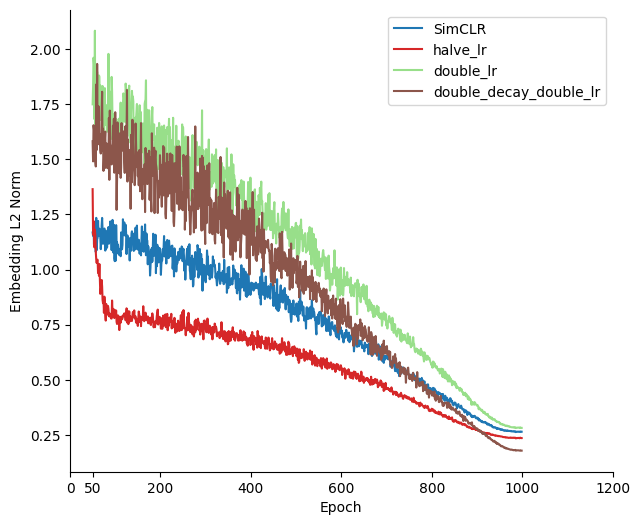

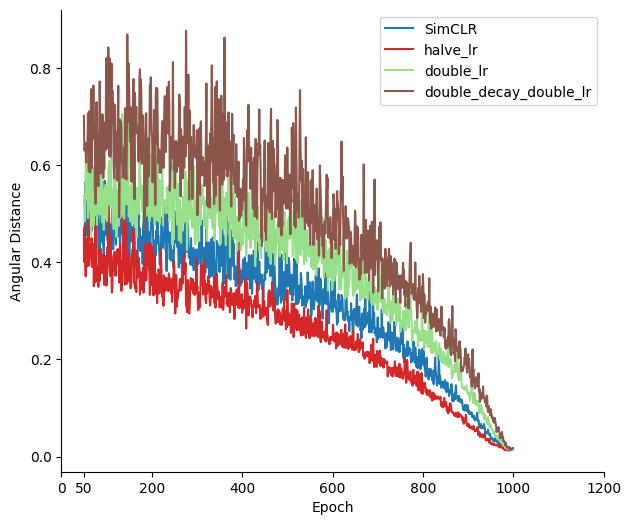

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from typing import Literal


def _plot_history(
        ax,
        embed_history,
        variant_name,
        color,
        from_epoch = 0,
        up_to_epoch = -1,
        only_mean = True,
        show_extremes = False
        ):

    history = embed_history[from_epoch:up_to_epoch]

    mean_values = history.mean(1)
    epochs = list(range(from_epoch, from_epoch+len(history)))
    ax.plot(epochs, mean_values, label=variant_name, color=color)

    if not only_mean:
        std_values = history.std(1)
        ax.fill_between(epochs, mean_values + std_values, mean_values-std_values, alpha=0.15, color=color)

    if show_extremes:
        min_values = history.min(1)
        max_values = history.max(1)
        ax.plot(epochs, max_values, label="max norm")
        ax.plot(epochs, min_values, label="min norm")

    ax.set_xlabel("Epoch")

def plot_histories(
        paths,
        metric_name: Literal["distance", "norm"] = "norm",
        from_epoch = 0,
        up_to_epoch = -1,
        only_mean = True
        ):
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(1,1, hspace=0)
    ax = gs.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
    history_type = dict(
        norm = "norm_history",
        distance = "distance_history" # this is angular distance
    )[metric_name]
    
    for variant_name, variant in paths.items():
        if type(variant) is tuple:
            variant_color, variant_path = variant
        else:
            variant_path = variant
            variant_color = None
        with open(variant_path, "rb") as f:
            embed_hist = np.load(f, allow_pickle=True).item()

        _plot_history(
            ax,
            embed_hist[history_type],
            variant_name,
            color=variant_color,
            from_epoch = from_epoch,
            up_to_epoch = up_to_epoch,
            only_mean=only_mean
            )
    
    metric_alias = dict(
        norm = "Embedding L2 Norm",
        distance = "Angular Distance"
    )[metric_name]

    ax.set_ylabel(metric_alias)

    # Add the first x-value if it's not already included
    xticks = ax.get_xticks()
    first_x = from_epoch
    if first_x not in xticks:
        xticks = np.insert(xticks, 0, first_x)
    ax.set_xticks(xticks)
    
    ax.legend()
    fig.show()
    

cmap = mpl.colormaps['tab20']

paths = dict(
    SimCLR = (cmap(0), "logs/No_schedule-_No_decay-1000/l2/SimCLR-1000/embed_history.npy"),
    # no_decay = (cmap(1), "logs/No_schedule-_No_decay-1000/l2/no_decay/embed_history.npy"),
    # no_decay_no_momentum = (cmap(2), "logs/No_schedule-_No_decay-1000/l2/no_decay-no_momentum/embed_history.npy"),
    # no_momentum = (cmap(9), "logs/No_schedule-_No_decay-1000/l2/no_momentum/embed_history.npy"),
    # no_schedule = (cmap(4), "logs/No_schedule-_No_decay-1000/l2/no_schedule/embed_history.npy"),
    # no_decay_no_schedule = (cmap(3), "logs/No_schedule-_No_decay-1000/l2/no_decay-no_schedule/embed_history.npy"),
    # mono = (cmap(5), "logs/Point_tracking-1000/mono/version_2/embed_history.npy"),
    # gradscale = (cmap(6), "logs/Point_tracking-1000/gradscale/version_46/embed_history.npy"),
    # inv_gradscale = (cmap(7), "logs/Point_tracking-1000/inv_gradscale/version_3/embed_history.npy"),
    halve_lr = (cmap(6), "logs/No_schedule-_No_decay-1000/l2/version_2/embed_history.npy"),
    # no_decay_double_lr = (cmap(8), "logs/No_schedule-_No_decay-1000/no_decay_double_lr/version_1/embed_history.npy"),
    double_lr = (cmap(5), "logs/No_schedule-_No_decay-1000/double_lr/version_1/embed_history.npy"),
    double_decay_double_lr = (cmap(10), "logs/No_schedule-_No_decay-1000/double_decay_double_lr/version_0/embed_history.npy")
)
from_epoch = 50
up_to_epoch = 1000
plot_histories(paths, metric_name="norm", from_epoch=from_epoch, up_to_epoch=up_to_epoch, only_mean=True)
plot_histories(paths, metric_name="distance", from_epoch=from_epoch, up_to_epoch=up_to_epoch, only_mean=True)

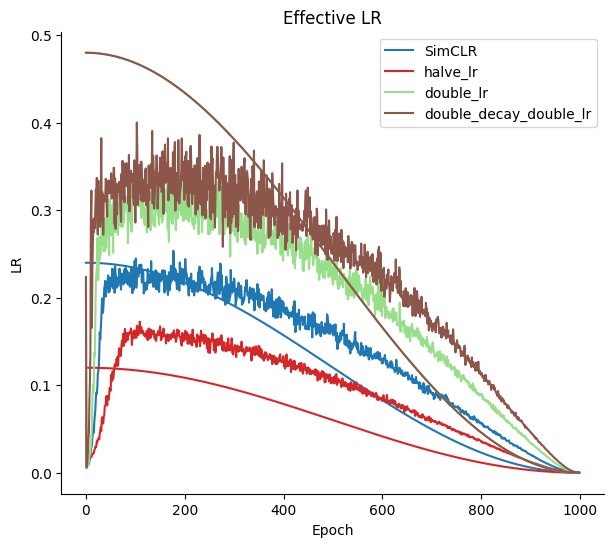

In [ ]:
from tbparse import SummaryReader
from matplotlib import pyplot as plt
import os
import numpy as np
import torch



def plot_effective_lr(npy_file_path, up_to_step = 1000, plot_lr_schedule=True):
    
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(1,1, hspace=0)
    ax = gs.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    _plot_effective_lr(ax, npy_file_path, up_to_step=up_to_step, plot_lr_schedule=plot_lr_schedule)
    plt.show()

def _plot_effective_lr(
        ax,
        npy_file_path,
        color=None,
        variant_name=None,
        from_step = 0,
        up_to_step = 1000,
        only_mean=True,
        plot_lr_schedule=True
        ):
    with open(npy_file_path, "rb") as f:
        embed_histories = np.load(f, allow_pickle=True).item()
    norm_hist = embed_histories["norm_history"][:-1]
    embed_norms_tensor = torch.tensor(norm_hist)[from_step:up_to_step]

    npy_file_folder = npy_file_path.replace("/embed_history.npy", "")
    log_dir = None
    for path in os.listdir(npy_file_folder):
        if "events" in path:
            log_dir = npy_file_folder + "/" + path

    reader = SummaryReader(log_dir)
    df = reader.scalars
    lr_schedule = torch.tensor(list(df[df.tag == "Cosine_Annealing_with_Warmup"].value))
    if lr_schedule.shape[0] == 0:
        print(variant_name, "no lr schedule found, this might be due to no schedule being used or the setting for saving the schedule being turned of, the following workaround assumes that infact no schedule was used during training")
        lr_schedule = torch.ones(len(embed_norms_tensor)) * df[df.tag == "lr-SGD"].iloc[0].value
    lr_schedule = lr_schedule[from_step:up_to_step]
    if len(lr_schedule) > len(embed_norms_tensor):
        lr_schedule = lr_schedule[:len(embed_norms_tensor)]

    effective_lr = lr_schedule.reshape(-1, 1)/embed_norms_tensor
    mean = effective_lr.mean(dim=-1)
    std = effective_lr.std(dim=-1)


    ax.plot(mean, label=variant_name, color=color)
    if not only_mean:
        ax.fill_between(range(len(embed_norms_tensor)), mean+std, mean-std, color=color, alpha=.15, label="std")

    if plot_lr_schedule:
        ax.plot(lr_schedule, color=color)
    # plt.plot(effective_lr.min(dim=-1).values, label="max effective LR")
    # plt.plot(effective_lr.max(dim=-1).values, label="min effective LR")
    ax.set_ylabel("LR")
    ax.set_xlabel("Epoch")
    ax.legend()
    ax.set_title("Effective LR")


def plot_effective_lrs(
        paths,
        from_step = 0,
        up_to_step = -1,
        only_mean = True,
        plot_lr_schedule=False
        ):
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(1,1, hspace=0)
    ax = gs.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for variant_name, variant in paths.items():
        if type(variant) is tuple:
            variant_color, variant_path = variant
        else:
            variant_path = variant
            variant_color = None

        _plot_effective_lr(
            ax,
            npy_file_path = variant_path,
            variant_name=variant_name,
            color=variant_color,
            from_step = from_step,
            up_to_step = up_to_step,
            only_mean=only_mean,
            plot_lr_schedule=plot_lr_schedule
            )
    
    ax.legend()
    fig.show()


paths = dict(
    SimCLR = (cmap(0), "logs/No_schedule-_No_decay-1000/l2/SimCLR-1000/embed_history.npy"),
    # no_decay = (cmap(1), "logs/No_schedule-_No_decay-1000/l2/no_decay/embed_history.npy"),
    # no_decay_no_momentum = (cmap(2), "logs/No_schedule-_No_decay-1000/l2/no_decay-no_momentum/embed_history.npy"),
    # no_momentum = (cmap(9), "logs/No_schedule-_No_decay-1000/l2/no_momentum/embed_history.npy"),
    # no_schedule = (cmap(4), "logs/No_schedule-_No_decay-1000/l2/no_schedule/embed_history.npy"),
    # no_decay_no_schedule = (cmap(3), "logs/No_schedule-_No_decay-1000/l2/no_decay-no_schedule/embed_history.npy"),
    # mono = (cmap(5), "logs/Point_tracking-1000/mono/version_2/embed_history.npy"),
    # gradscale = (cmap(6), "logs/Point_tracking-1000/gradscale/version_46/embed_history.npy"),
    # inv_gradscale = (cmap(7), "logs/Point_tracking-1000/inv_gradscale/version_3/embed_history.npy"),
    halve_lr = (cmap(6), "logs/No_schedule-_No_decay-1000/l2/version_2/embed_history.npy"),
    # no_decay_double_lr = (cmap(8), "logs/No_schedule-_No_decay-1000/no_decay_double_lr/version_1/embed_history.npy"),
    double_lr = (cmap(5), "logs/No_schedule-_No_decay-1000/double_lr/version_1/embed_history.npy"),
    double_decay_double_lr = (cmap(10), "logs/No_schedule-_No_decay-1000/double_decay_double_lr/version_0/embed_history.npy")
)

plot_effective_lrs(paths, plot_lr_schedule=True)

/tmp/ipykernel_3178065/177502469.py:47: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  effective_lr = lr_schedule.reshape(-1, 1)/embed_norms_tensor
/tmp/ipykernel_3178065/177502469.py:47: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  effective_lr = lr_schedule.reshape(-1, 1)/embed_norms_tensor
/tmp/ipykernel_3178065/177502469.py:47: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  effective_lr = lr_schedule.reshape(-1, 1)/embed_norms_tensor
/tmp/ipykernel_3178065/177502469.py:47: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  effective_lr = lr_schedule.reshape(-1, 1)/embed_norms_tensor
/tmp/ipykernel_3178065/177502469.py:47: Depr

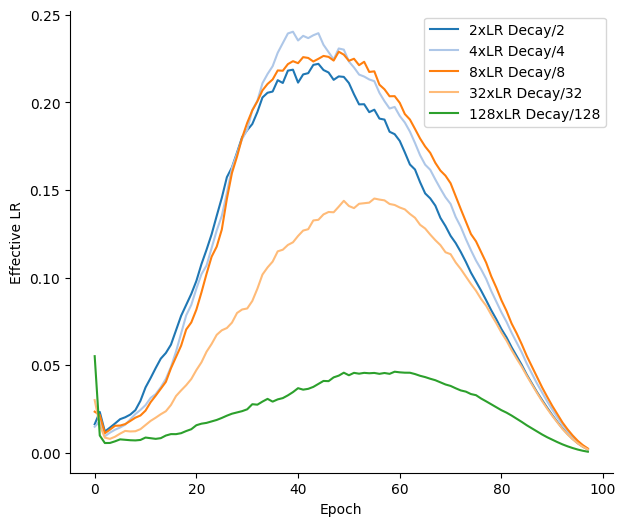

In [56]:
from tbparse import SummaryReader
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import torch


def interweave(a,b):
    c = np.empty((a.shape[0] + b.shape[0], a.shape[1]), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

def _plot_effective_lr2(
        ax,
        npy_file_path,
        color=None,
        variant_name=None,
        from_step = 0,
        up_to_step = 1000,
        only_mean=True,
        plot_lr_schedule=True
        ):
    with open(npy_file_path, "rb") as f:
        embed_histories = np.load(f, allow_pickle=True).item()
    norm_hist = embed_histories["train_norm_history"][:-1]
    embed_norms_tensor = torch.tensor(norm_hist)[from_step:up_to_step]
    embed_norms_tensor = interweave(embed_norms_tensor.numpy()[:,0], embed_norms_tensor.numpy()[:,1])

    npy_file_folder = npy_file_path.replace("/embed_history.npy", "")
    log_dir = None
    for path in os.listdir(npy_file_folder):
        if "events" in path:
            log_dir = npy_file_folder + "/" + path

    reader = SummaryReader(log_dir)
    df = reader.scalars
    lr_schedule = torch.tensor(list(df[df.tag == "schedule"].value)).repeat_interleave(2)
    if lr_schedule.shape[0] == 0:
        print(variant_name, "no lr schedule found, this might be due to no schedule being used or the setting for saving the schedule being turned of, the following workaround assumes that infact no schedule was used during training")
        lr_schedule = torch.ones(len(embed_norms_tensor)) * df[df.tag == "lr-SGD"].iloc[0].value
    lr_schedule = lr_schedule[from_step:up_to_step]
    if len(lr_schedule) > len(embed_norms_tensor):
        lr_schedule = lr_schedule[:len(embed_norms_tensor)]
    
    effective_lr = lr_schedule.reshape(-1, 1)/embed_norms_tensor
    mean = effective_lr.mean(dim=-1)
    std = effective_lr.std(dim=-1)

    x = torch.arange(0,len(mean)//2).repeat_interleave(2)
    ax.plot(x , mean, label=variant_name, color=color)
    if not only_mean:
        ax.fill_between(x, mean+std, mean-std, color=color, alpha=.15, label="std")

    if plot_lr_schedule:
        ax.plot(x, lr_schedule, color=color)
    # plt.plot(effective_lr.min(dim=-1).values, label="max effective LR")
    # plt.plot(effective_lr.max(dim=-1).values, label="min effective LR")
    ax.set_ylabel("Effective LR")
    ax.set_xlabel("Epoch")
    ax.legend()
    # ax.set_title("Effective LR")


def plot_effective_lrs2(
        paths,
        from_step = 0,
        up_to_step = -1,
        only_mean = True,
        plot_lr_schedule=False
        ):
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(1,1, hspace=0)
    ax = gs.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for variant_name, variant in paths.items():
        if type(variant) is tuple:
            variant_color, variant_path = variant
        else:
            variant_path = variant
            variant_color = None

        _plot_effective_lr2(
            ax,
            npy_file_path = variant_path,
            variant_name=variant_name,
            color=variant_color,
            from_step = from_step,
            up_to_step = up_to_step,
            only_mean=only_mean,
            plot_lr_schedule=plot_lr_schedule
            )
    
    ax.legend()
    fig.show()


cmap = mpl.colormaps['tab20']

paths = {
    "2xLR Decay/2": (cmap(0), "logs/reruns/lr_weight_decay_rebalance/l2/version_0/embed_history.npy"),
    "4xLR Decay/4": (cmap(1), "logs/reruns/lr_weight_decay_rebalance/l2/version_1/embed_history.npy"),
    "8xLR Decay/8": (cmap(2), "logs/reruns/lr_weight_decay_rebalance/l2/version_2/embed_history.npy"),
    "32xLR Decay/32": (cmap(3), "logs/reruns/lr_weight_decay_rebalance/l2/version_3/embed_history.npy"),
    "128xLR Decay/128": (cmap(4), "logs/reruns/lr_weight_decay_rebalance/l2/version_4/embed_history.npy"),
}

plot_effective_lrs2(paths, plot_lr_schedule=False, only_mean=True)

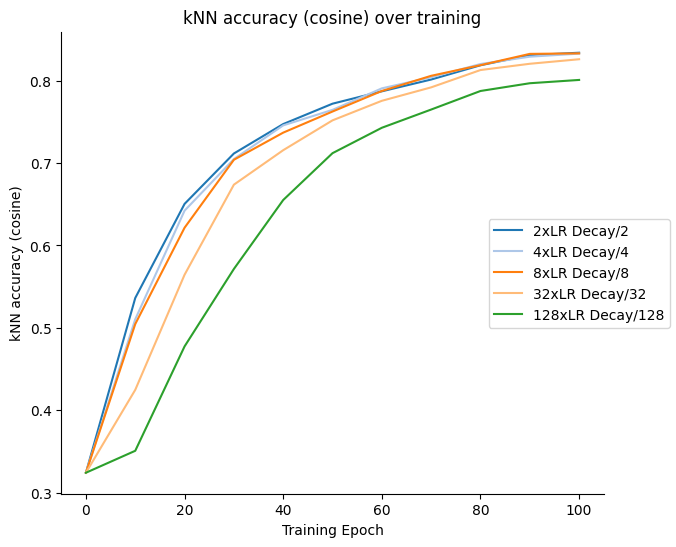

In [57]:
def plot_accuracies(
        paths
):  
    fig = plt.figure(figsize=(7, 6))
    gs = fig.add_gridspec(1,1, hspace=0)
    ax = gs.subplots()

    for name, (color, npy_file_path) in paths.items():
        npy_file_folder = npy_file_path.replace("/embed_history.npy", "")
        log_dir = None
        for path in os.listdir(npy_file_folder):
                if "events" in path:
                        log_dir = npy_file_folder + "/" + path
        reader = SummaryReader(log_dir)
        df = reader.scalars
        acc = torch.tensor(list(df[df.tag == "kNN accuracy (cosine)"].value))
        x = 10 * torch.arange(0, len(acc))
        ax.plot(x, acc, label=name, c=color)

    ax.set_xlabel("Training Epoch")
    ax.set_ylabel("kNN accuracy (cosine)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title("kNN accuracy (cosine) over training")
    fig.legend(loc="center right")
    fig.show()

    
# paths = {
#       "SimCLR": ("black", "logs/reruns/SimCLR/version_0/embed_history.npy"),
#       "Angle representation": (cmap(0), "logs/reruns/mappings_onto_hypersphere/angle/version_0/embed_history.npy"),
#       "Angle representation (second seed)": (cmap(1), "logs/reruns/mappings_onto_hypersphere/angle/version_1/embed_history.npy"),
#       "Angle2 representation": (cmap(2), "logs/reruns/mappings_onto_hypersphere/angle2/version_0/embed_history.npy"),
#       "Mono": (cmap(4), "logs/reruns/mappings_onto_hypersphere/mono/version_0/embed_history.npy"),
#       "Stereographic projection": (cmap(8), "logs/reruns/mappings_onto_hypersphere/stereo/version_0/embed_history.npy"),
# }

plot_accuracies(paths)

In [ ]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2
from utils.plotting_utils import *

env: CUDA_VISIBLE_DEVICES=2


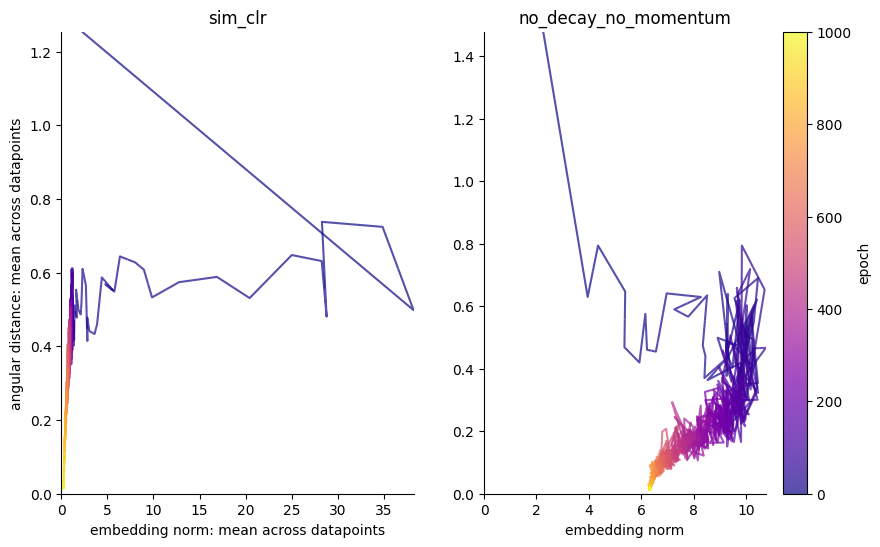

In [ ]:
from utils.plotting_utils import plot_paths_mean_over_extreme_points_dist_norm_epoch

paths = dict(
    sim_clr = "logs/No_schedule-_No_decay-1000/l2/SimCLR-1000/embed_history.npy",
    # no_decay = "logs/No_schedule-_No_decay-1000/l2/no_decay/embed_history.npy",
    no_decay_no_momentum = "logs/No_schedule-_No_decay-1000/l2/no_decay-no_momentum/embed_history.npy",
    # no_decay_no_schedule = "logs/No_schedule-_No_decay-1000/l2/no_decay-no_schedule/embed_history.npy",
    # no_schedule = "logs/No_schedule-_No_decay-1000/l2/no_schedule/embed_history.npy",
    # mono = "logs/Point_tracking-1000/mono/version_2/embed_history.npy",
    # gradscale = "logs/Point_tracking-1000/gradscale/version_46/embed_history.npy",
    # inv_gradscale = "logs/Point_tracking-1000/inv_gradscale/version_3/embed_history.npy",
)
starting_epoch = 0
moving_average_size = 1
line_or_scatter = "line"
share_axis = False
only_mean = True

plot_paths_mean_over_extreme_points_dist_norm_epoch(
    paths,
    starting_epoch=starting_epoch,
    extreme_at_end_in="norm",
    share_axis=share_axis,
    moving_average_size=moving_average_size,
    line_or_scatter=line_or_scatter,
    only_mean=only_mean
    )

In [ ]:
plot_paths_mean_over_extreme_points_dist_norm_epoch(
    paths,
    starting_epoch=starting_epoch,
    extreme_at_end_in="distance",
    share_axis=share_axis,
    moving_average_size=moving_average_size,
    line_or_scatter=line_or_scatter,
    only_mean=only_mean
    )

In [ ]:
import numpy as np


variant = dict(
    sim_clr = "logs/No_schedule-_No_decay-1000/l2/SimCLR-1000/embed_history.npy",
    gradscale = "logs/Point_tracking-1000/gradscale/version_46/embed_history.npy",
    inv_gradscale = "logs/Point_tracking-1000/inv_gradscale/version_3/embed_history.npy",
    no_decay = "logs/No_schedule-_No_decay-1000/l2/no_decay/embed_history.npy",
    no_decay_no_momentum = "logs/No_schedule-_No_decay-1000/l2/no_decay-no_momentum/embed_history.npy",
    no_decay_no_schedule = "logs/No_schedule-_No_decay-1000/l2/no_decay-no_schedule/embed_history.npy",
    no_schedule = "logs/No_schedule-_No_decay-1000/l2/no_schedule/embed_history.npy",
    mono = "logs/Point_tracking-1000/mono/version_2/embed_history.npy",
    with_certainty = "logs/No_schedule-_No_decay-1000/l2/with_certainty-1000/embed_history.npy",
    new_history_style = "logs/No_schedule-_No_decay-1000/l2/version_2/embed_history.npy",
    SimCLR = "logs/reruns/SimCLR/version_0/embed_history.npy",
)["SimCLR"]


with open(variant, "rb") as f:
    embed_histories = np.load(f, allow_pickle=True).item()

embed_histories["grad_norm_history"].shape

(1000, 2, 50000)

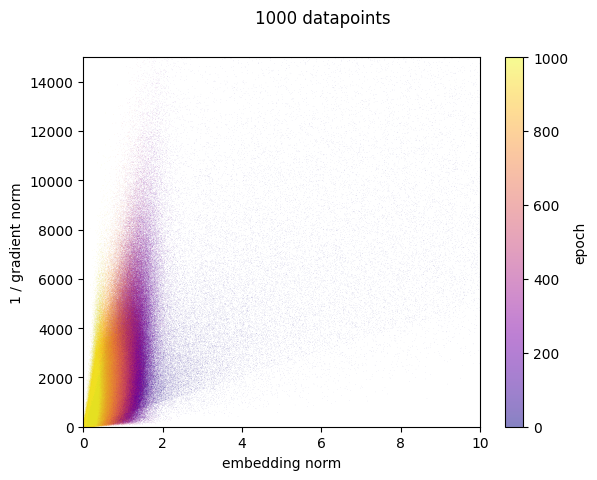

In [53]:
from matplotlib import pyplot as plt

def interweave(a,b):
    c = np.empty((a.shape[0] + b.shape[0], a.shape[1]), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

def plt_gradient_norm_embedding_norm(embed_histories, idx_count, start_from_epoch, log_scale=False, take_mean = False):

    grad_norm_history = embed_histories["grad_norm_history"]
    train_norm_history = embed_histories["train_norm_history"]

    if take_mean:
        y = interweave(grad_norm_history[:,0], grad_norm_history[:,1])[2*start_from_epoch:, :idx_count].mean(1)
        x = 1/interweave(train_norm_history[:,0], train_norm_history[:,1])[2*start_from_epoch:, :idx_count].mean(1)
    else:
        # interweaving view 1 and view 2 norm, because during training there are always 2 views
        y = 1/interweave(grad_norm_history[:,0], grad_norm_history[:,1])[2*start_from_epoch:, :idx_count]
        x = interweave(train_norm_history[:,0], train_norm_history[:,1])[2*start_from_epoch:, :idx_count]
    

    epoch_n = grad_norm_history.shape[0]
    # repeat 2 for 2 views
    color = np.repeat(np.linspace(start_from_epoch, epoch_n, int(len(x)/2)),2)
    if not take_mean:
        color = color.repeat(idx_count)
    cmap = "plasma"

    scatter = plt.scatter(x, y, c=color, cmap=cmap, alpha=.5, edgecolors='none', s=0.05)
    plt.colorbar(scatter, label="epoch", alpha=1)
    plt.ylabel("1 / gradient norm")
    plt.xlabel("embedding norm")
    if log_scale:
        plt.xscale("log")
        plt.yscale("log")
    if take_mean:
        plt.suptitle(f"Mean across {idx_count} datapoints")
    else:
        plt.suptitle(f"{idx_count} datapoints")
    plt.xlim(0,10)
    plt.ylim(0,15000)
    plt.show()

plt_gradient_norm_embedding_norm(embed_histories, idx_count=1000, start_from_epoch=0, log_scale=False, take_mean=False, )

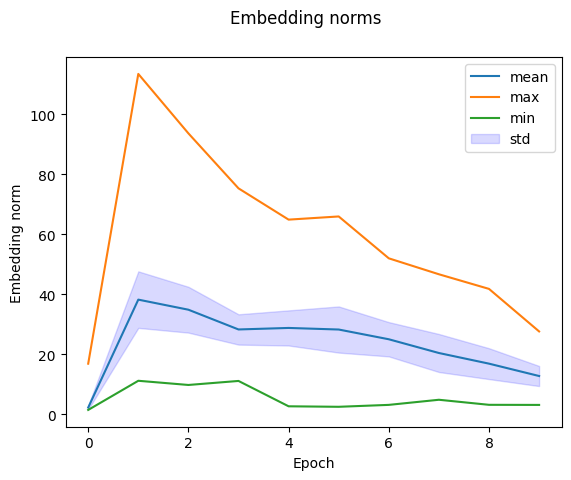

In [4]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd

up_to_step = 10
embed_norms_tensor = torch.tensor(norm_hist)[:up_to_step]
mean = embed_norms_tensor.mean(dim=-1)
std = embed_norms_tensor.std(dim=-1)

plt.plot(embed_norms_tensor.mean(dim=-1), label="mean")
plt.plot(embed_norms_tensor.max(dim=-1).values, label="max")
plt.plot(embed_norms_tensor.min(dim=-1).values, label="min")
plt.fill_between(range(len(embed_norms_tensor)), mean+std, mean-std, color='b', alpha=.15, label="std")
plt.suptitle("Embedding norms")
plt.ylabel("Embedding norm")
plt.xlabel("Epoch")
plt.legend()
# plt.yscale("log")
plt.show()

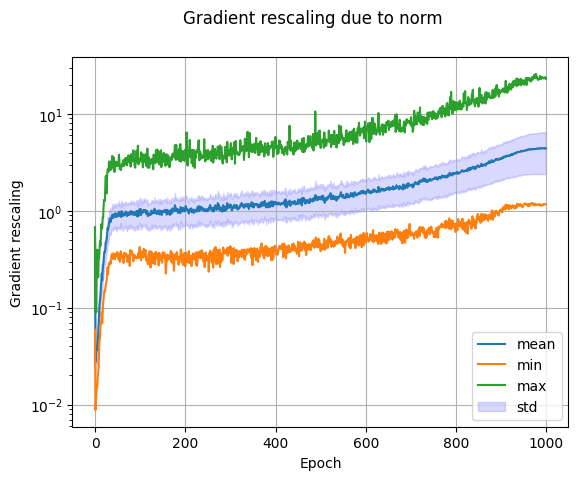

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd

up_to_step = 1000
embed_norms_tensor = torch.tensor(norm_hist)[:up_to_step]
gradient_rescaling = 1/embed_norms_tensor
mean = gradient_rescaling.mean(dim=-1)
std = gradient_rescaling.std(dim=-1)

plt.plot(gradient_rescaling.mean(dim=-1), label="mean")
plt.plot(gradient_rescaling.min(dim=-1).values, label="min")
plt.plot(gradient_rescaling.max(dim=-1).values, label="max")
plt.fill_between(range(len(gradient_rescaling)), mean+std, mean-std, color='b', alpha=.15, label="std")
plt.suptitle("Gradient rescaling due to norm")
plt.ylabel("Gradient rescaling")
plt.xlabel("Epoch")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

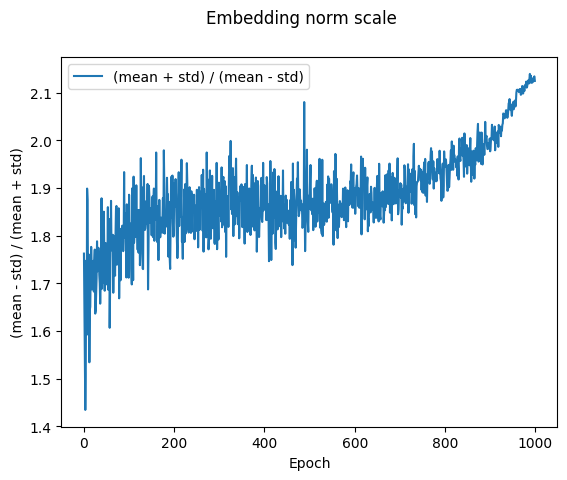

In [8]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import pandas as pd

up_to_step = 1000
embed_norms_tensor = torch.tensor(norm_hist)[:up_to_step]
mean = embed_norms_tensor.mean(dim=-1)
std = embed_norms_tensor.std(dim=-1)

# plt.plot(embed_norms_tensor.max(dim=-1).values / embed_norms_tensor.min(dim=-1).values, label="Embed norm: max/min")
plt.plot((mean+std)/(mean-std), label="(mean + std) / (mean - std)")
plt.suptitle("Embedding norm scale")
plt.ylabel("(mean - std) / (mean + std)")
plt.xlabel("Epoch")
plt.legend()
# plt.yscale("log")
plt.show()

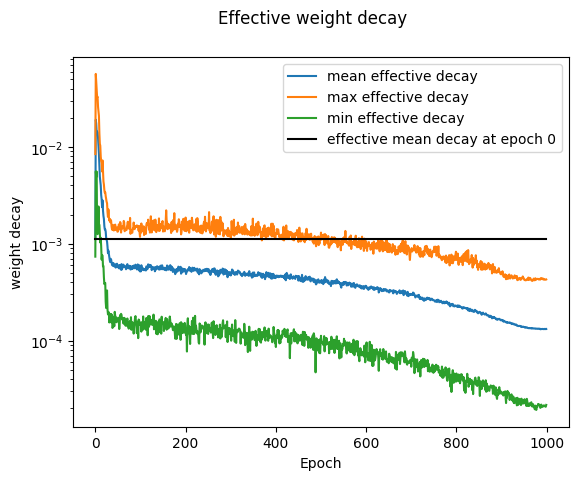

In [5]:
weight_decay = 0.0005

plt.plot(weight_decay*norm_hist.mean(axis=-1), label="mean effective decay")
plt.plot(weight_decay*norm_hist.max(axis=-1), label="max effective decay")
plt.plot(weight_decay*norm_hist.min(axis=-1), label="min effective decay")
plt.plot([weight_decay*norm_hist.mean(axis=-1)[0]]*len(norm_hist), label="effective mean decay at epoch 0", color="black") # Effective weight decay at epoch 0
plt.legend()
plt.suptitle("Effective weight decay")
plt.yscale("log")
plt.ylabel("weight decay")
plt.xlabel("Epoch")
plt.show()

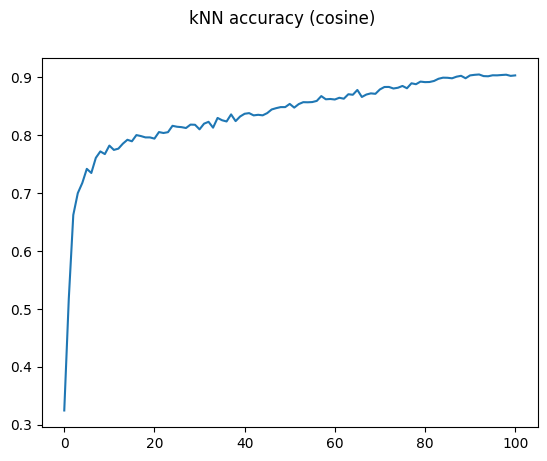

In [6]:
knn_acc = list(df[df.tag == "kNN accuracy (cosine)"].value)
plt.plot(knn_acc)
plt.suptitle("kNN accuracy (cosine)")
plt.show()

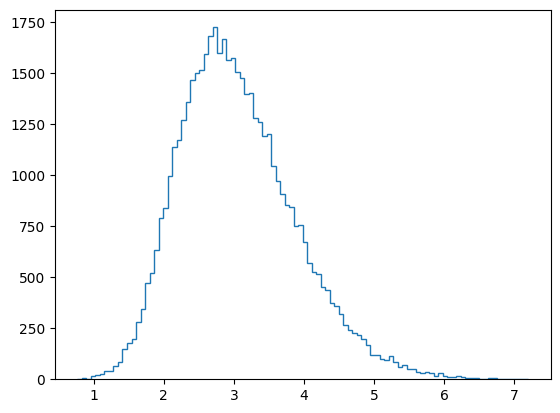

In [36]:
counts, bins = embed_norms_tensor[20].histogram()
plt.stairs(counts, bins)
# plt.yscale("log")